# Simulacion de eventos discretos del COVID-19
## Datos:
Datos de la provincia de Imbambura:
Total: 3 hospitales, 11 camas, 11 respiradores, 11 equipos de radiología, personal 150, 1.13% de camas por cada 1000 pesonas.
- Hospital 1: Camas 7, respiradores 7, 7 equipos de radiologia, 0 ventiladores
- Hospital 2: Camas 4, respiradores 4, 4 ventiladores
- Hospital 3: (IESS no se tiene infomacion)

### Datos estadisticos:

- Tasa de crecimiento: 7 (Modelo de probabilidad)
- Infectados actuales: 99

## Modelo Propuesto

Generar un modelo del uso de los recursos de los hospitales para la atencion de las personas que tiene el COVID-19 en base a los datos presentados, por cada uno de los dias.



Simulacion COVID 19
Llega paciente nuevo :  0  hospital A tiempo  0
Llega paciente nuevo :  1  hospital B tiempo  0
Llega paciente nuevo :  2  hospital B tiempo  0
Llega paciente nuevo :  3  hospital A tiempo  0
Llega paciente nuevo :  4  hospital B tiempo  0
Llega paciente nuevo :  5  hospital A tiempo  0
Llega paciente nuevo :  6  hospital A tiempo  0
Llega paciente nuevo :  7  hospital A tiempo  0
Llega paciente nuevo :  8  hospital A tiempo  0
Llega paciente nuevo :  9  hospital B tiempo  0
Llega paciente nuevo :  10  hospital A tiempo  0
Llega paciente nuevo :  11  hospital B tiempo  0
Llega paciente nuevo :  12  hospital B tiempo  0
Llega paciente nuevo :  13  hospital A tiempo  0
Llega paciente nuevo :  14  hospital A tiempo  0
Llega paciente nuevo :  15  hospital B tiempo  0
Llega paciente nuevo :  16  hospital B tiempo  0
Llega paciente nuevo :  17  hospital B tiempo  0
Llega paciente nuevo :  18  hospital B tiempo  0
Llega paciente nuevo :  19  hospital B tiempo  0
El pacient

Llega paciente nuevo :  152  hospital A tiempo  19
Llega paciente nuevo :  153  hospital A tiempo  19
El paciente no tiene COVID :  148  hospital  B
El paciente no tiene COVID :  151  hospital  A
El paciente  112  en el hospital  B  espero  5  dias y fallece no hay camas
El paciente  113  en el hospital  A  espero  5  dias y fallece no hay camas
El paciente  126  en el hospital  A  espero  3  dias y fallece no hay camas
El paciente  138  en el hospital  B  espero  2  dias y fallece no hay camas
Al paciente:  134  se le asigna una CAMA   hospital  B
Al paciente:  125  se le asigna una CAMA   hospital  A
Al paciente:  127  se le asigna una CAMA   hospital  A
Resultados pacientes :
Recuperados: 
{5: 1, 6: 2, 8: 2, 11: 2, 12: 1, 13: 1, 14: 2, 15: 1, 19: 3}
Fallecidos: 
{1: 2, 2: 1, 4: 3, 5: 6, 6: 3, 7: 2, 8: 3, 9: 1, 10: 4, 11: 11, 12: 1, 13: 2, 14: 3, 15: 7, 16: 3, 17: 1, 18: 1, 19: 4}


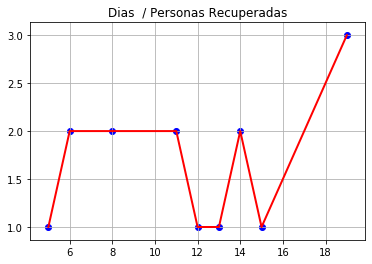

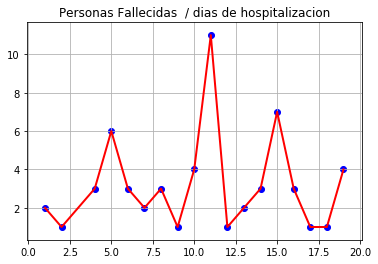

In [3]:
import simpy
import random
import matplotlib.pyplot as pp
import numpy as np

%matplotlib inline


#PARAMETROS
HOSPITALES = 2
HOSPITAL_CAMA_A = 7
HOSPITAL_CAMA_B = 4
HOSPITAL_VENT_A = 7
HOSPITAL_VENT_B = 4
INFECTADOS = 20
TASA_CRECIMIENTO = 7
PERSONAL_MEDICO = 150
DIAS_INTERNADO = 10
DIAS_SIMULACION = 20

#Diccionario para almacenar los resultados
persona_recuperadas={}
persona_fallecidas={}


class Hospital(object):
    #constructor
    def __init__(self, env, num_cama, name):
            self.env = env
            self.num_cama = num_cama
            self.camas = simpy.Resource(env, num_cama)
            self.name = name
            
    def ingresar_paciente(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-5, DIAS_INTERNADO+5))
        print("El paciente se termino de atender: ", paciente, " tiempo de salida: ", self.env.now, " hospital ", self.name)

def llegada_paciente(env, hospital, paciente):
    arrive = env.now
    estado = random.randint(1,100)
    if (estado < 60):
        with hospital.camas.request() as cama:
            dias_esperando = random.randint(1,5) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
            requerimiento = yield cama | env.timeout(dias_esperando) #Asignar un tiempo de espera
            wait = env.now - arrive
            if cama in requerimiento:
                yield env.process(hospital.ingresar_paciente(paciente))
                estado = random.randint(1,100)
                if (estado < 8) :
                    persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                else:
                    persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1
            else:
                print("El paciente " , paciente, " en el hospital ", hospital.name, " espero ", wait , " dias y fallece no hay camas")
                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1        
    else :
        print("El paciente no tiene COVID : ", paciente, " hospital ", hospital.name )

def ejecutar(env, tasa_crecimiento, infectados):
    hospitalA = Hospital(env, HOSPITAL_CAMA_A, "A")
    hospitalB = Hospital(env, HOSPITAL_CAMA_B, "B")
    for i in range(infectados):
        asignar_hospital(env, hospitalA, hospitalB, i)
    paciente = infectados
    while True:
        yield env.timeout(1)
        for i in range(tasa_crecimiento):
            paciente += 1
            asignar_hospital(env, hospitalA, hospitalB, paciente)
                
def asignar_hospital(env, hospitalA, hospitalB, paciente):
    hosp_esc = random.randint(1,2)
    if (hosp_esc == 1):
        print("Llega paciente nuevo : ", paciente, " hospital A tiempo ", env.now)
        env.process(llegada_paciente(env, hospitalA, paciente))
    else:
        print("Llega paciente nuevo : ", paciente, " hospital B tiempo ", env.now)
        env.process(llegada_paciente(env, hospitalB, paciente))
    
print("Simulacion COVID 19")
env=simpy.Environment()
env.process(ejecutar(env,TASA_CRECIMIENTO, INFECTADOS))
env.run(until=DIAS_SIMULACION)

print("Resultados pacientes :")
print("Recuperados: ")
print(persona_recuperadas)
print("Fallecidos: ")
print(persona_fallecidas)

datos=sorted(persona_recuperadas.items()) # Ordenamos los datos
x, y =zip(*datos) # Obtener x(tiempo - clave) y el y(Numero de vehiculos atendidos - valor)
pp.plot(x,y,linewidth=2,color='red') #Dibujamos las lineas
pp.scatter(x,y,color='blue') # Dibujamos los puntos (x,y)
pp.title("Dias  / Personas Recuperadas")
pp.grid(True) #Generamos una cuadricula
pp.show() #Mostramos el grafico

if (persona_fallecidas):
    datos=sorted(persona_fallecidas.items()) # Ordenamos los datos
    x, y =zip(*datos) # Obtener x(tiempo - clave) y el y(Numero de vehiculos atendidos - valor)
    pp.plot(x,y,linewidth=2,color='red') #Dibujamos las lineas
    pp.scatter(x,y,color='blue') # Dibujamos los puntos (x,y)
    pp.title("Personas Fallecidas  / dias de hospitalizacion")
    pp.grid(True) #Generamos una cuadricula
    pp.show() #Mostramos el grafico

    